In [0]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from IPython.display import Image
import pydotplus
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# https://drive.google.com/open?id=1wWRxTCgIsk0HlOI9ABvjsD0OFz-1CiIh
file_id = '1wWRxTCgIsk0HlOI9ABvjsD0OFz-1CiIh'
downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

     |████████████████████████████████| 993kB 3.4MB/s 

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Data Loading and treating missing values

In [0]:
downloaded.GetContentFile('h1_b.csv')

In [4]:
df = pd.read_csv('h1_b.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,16,17,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. Check the shape 

In [5]:
df.shape

(624650, 52)

In [6]:
df.isnull().sum()

CASE_NUMBER                         0
CASE_STATUS                         0
CASE_SUBMITTED                      0
DECISION_DATE                       0
VISA_CLASS                          0
EMPLOYMENT_START_DATE              29
EMPLOYMENT_END_DATE                30
EMPLOYER_NAME                      56
EMPLOYER_BUSINESS_DBA          581380
EMPLOYER_ADDRESS                    7
EMPLOYER_CITY                      15
EMPLOYER_STATE                     18
EMPLOYER_POSTAL_CODE               18
EMPLOYER_COUNTRY                96507
EMPLOYER_PROVINCE              618534
EMPLOYER_PHONE                  96508
EMPLOYER_PHONE_EXT             596778
AGENT_REPRESENTING_EMPLOYER     96506
AGENT_ATTORNEY_NAME                 0
AGENT_ATTORNEY_CITY            273306
AGENT_ATTORNEY_STATE           288641
JOB_TITLE                           5
SOC_CODE                            2
SOC_NAME                            3
NAICS_CODE                          7
TOTAL_WORKERS                       0
NEW_EMPLOYME

**Based on the null information and their relevance below columns can be droped: **
drop_cols = ['EMPLOYER_ADDRESS', 'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT', 'EMPLOYER_NAME', 'EMPLOYER_BUSINESS_DBA', 'EMPLOYER_PROVINCE', 'ORIGINAL_CERT_DATE', 'PUBLIC_DISCLOSURE_LOCATION', ''CASE_NUMBER'']
1. dropping since all the values of PUBLIC_DISCLOSURE_LOCATION are none
2. drop CASE_NUMBER as index number is the key
3. Select data between 1st Oct 2016 to 30th June 2017

In [0]:
cols_to_be_dropped = ['EMPLOYER_ADDRESS', 'EMPLOYER_PHONE', 'EMPLOYER_PHONE_EXT', 
                      'EMPLOYER_BUSINESS_DBA','EMPLOYER_PROVINCE', 'ORIGINAL_CERT_DATE', 
                      'PUBLIC_DISCLOSURE_LOCATION', 'CASE_NUMBER']

In [0]:
df.drop(labels=cols_to_be_dropped, axis=1, inplace=True)

In [0]:
df = df[(df['CASE_SUBMITTED'] < '2017-06-30') & (df['CASE_SUBMITTED'] > '2016-10-01')]

In [10]:
df.shape

(503213, 44)

In [0]:
numerical_cols = df.select_dtypes(exclude='object').columns

In [0]:
categorical_cols = df.select_dtypes(include='object').columns

In [13]:
numerical_cols

Index(['TOTAL_WORKERS', 'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT',
       'CHANGE_PREVIOUS_EMPLOYMENT', 'NEW_CONCURRENT_EMPLOYMENT',
       'CHANGE_EMPLOYER', 'AMENDED_PETITION', 'PREVAILING_WAGE',
       'PW_SOURCE_YEAR', 'WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO'],
      dtype='object')

In [14]:
categorical_cols

Index(['CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE', 'VISA_CLASS',
       'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE', 'EMPLOYER_NAME',
       'EMPLOYER_CITY', 'EMPLOYER_STATE', 'EMPLOYER_POSTAL_CODE',
       'EMPLOYER_COUNTRY', 'AGENT_REPRESENTING_EMPLOYER',
       'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE',
       'JOB_TITLE', 'SOC_CODE', 'SOC_NAME', 'NAICS_CODE', 'FULL_TIME_POSITION',
       'PW_UNIT_OF_PAY', 'PW_WAGE_LEVEL', 'PW_SOURCE', 'PW_SOURCE_OTHER',
       'WAGE_UNIT_OF_PAY', 'H1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'SUPPORT_H1B',
       'LABOR_CON_AGREE', 'WORKSITE_CITY', 'WORKSITE_COUNTY', 'WORKSITE_STATE',
       'WORKSITE_POSTAL_CODE'],
      dtype='object')

Below Categorical Columns can be label encoded

1.   VISA_CLASS
2.   AGENT_REPRESENTING_EMPLOYER
3.   FULL_TIME_POSITION
4.   PW_UNIT_OF_PAY
5.   PW_WAGE_LEVEL
6.   PW_SOURCE
7.   WAGE_UNIT_OF_PAY
8.   H1B_DEPENDENT
9.   WILLFUL_VIOLATOR
10. SUPPORT_H1B
11. LABOR_CON_AGREE
12. WORKSITE_STATE


In [15]:
df[categorical_cols].describe().T

,count,unique,top,freq
CASE_STATUS,503213,4,CERTIFIED,461052
CASE_SUBMITTED,503213,267,2017-03-15,12287
DECISION_DATE,503213,345,2017-03-23,17329
VISA_CLASS,503213,4,H-1B,492902
EMPLOYMENT_START_DATE,503196,469,2017-09-01,25740
EMPLOYMENT_END_DATE,503196,1453,2020-08-31,15896
EMPLOYER_NAME,503169,63578,INFOSYS LIMITED,17101
EMPLOYER_CITY,503199,4839,PLANO,28735
EMPLOYER_STATE,503198,56,CA,86313
EMPLOYER_POSTAL_CODE,503197,10332,75024,18772


In [16]:
df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
TOTAL_WORKERS,503213.0,1.947636,5.035007,0.0,1.0,1.0,1.0,155.0
NEW_EMPLOYMENT,503213.0,0.947686,3.865716,0.0,0.0,1.0,1.0,150.0
CONTINUED_EMPLOYMENT,503213.0,0.310769,1.205357,0.0,0.0,0.0,0.0,55.0
CHANGE_PREVIOUS_EMPLOYMENT,503213.0,0.125674,0.889172,0.0,0.0,0.0,0.0,50.0
NEW_CONCURRENT_EMPLOYMENT,503213.0,0.009239,0.168280,0.0,0.0,0.0,0.0,50.0
CHANGE_EMPLOYER,503213.0,0.240423,1.056729,0.0,0.0,0.0,0.0,150.0
AMENDED_PETITION,503213.0,0.313893,1.382828,0.0,0.0,0.0,0.0,50.0
PREVAILING_WAGE,503213.0,72233.258963,286312.984802,0.0,56035.0,68827.0,87381.0,201622735.0
PW_SOURCE_YEAR,503181.0,2016.125267,5.687433,0.0,2016.0,2016.0,2016.0,2017.0
WAGE_RATE_OF_PAY_FROM,503213.0,81711.901193,42711.647176,0.0,62275.0,75000.0,97843.0,1688000.0


date_cols = ['DECISION_DATE',  'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE', 'ORIGINAL_CERT_DATE',  'CASE_SUBMITTED']

In [0]:
date_cols = ['DECISION_DATE',  'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE', 'CASE_SUBMITTED']

In [0]:
for col in date_cols:
  df[col] = pd.to_datetime(df[col])
  df[col+'_DAY'] = df[col].apply(lambda x:x.day)
  df[col+'_MONTH'] = df[col].apply(lambda x:x.month)
  df[col+'_YEAR'] = df[col].apply(lambda x:x.year)
  df.drop(labels=col, axis=1, inplace=True)

In [19]:
df.shape

(503213, 52)

In [20]:
df.head()

,CASE_STATUS,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_POSTAL_CODE,EMPLOYER_COUNTRY,AGENT_REPRESENTING_EMPLOYER,AGENT_ATTORNEY_NAME,AGENT_ATTORNEY_CITY,...,DECISION_DATE_YEAR,EMPLOYMENT_START_DATE_DAY,EMPLOYMENT_START_DATE_MONTH,EMPLOYMENT_START_DATE_YEAR,EMPLOYMENT_END_DATE_DAY,EMPLOYMENT_END_DATE_MONTH,EMPLOYMENT_END_DATE_YEAR,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR
16,WITHDRAWN,H-1B,ITAS INC,INDIANAPOLIS,IN,46240,UNITED STATES OF AMERICA,Y,"SHAH, JATIN",INDIANAPOLIS,...,2016,8.0,10.0,2016.0,7.0,10.0,2019.0,2,10,2016
1501,WITHDRAWN,H-1B,THRIVESOFT INC,BOTHELL,WA,98021,UNITED STATES OF AMERICA,N,",",NaN,...,2016,3.0,10.0,2016.0,1.0,9.0,2019.0,3,10,2016
1502,WITHDRAWN,H-1B,"BOSS TECHNOLOGIES, INC",ALPHARETTA,GA,30022,UNITED STATES OF AMERICA,Y,"SIKAL, SOWMIYA",ALPHARETTA,...,2016,3.0,10.0,2016.0,2.0,10.0,2019.0,3,10,2016
1503,WITHDRAWN,H-1B,INVENTIV HEALTH CLINICAL LLC,PRINCETON,NJ,08540,UNITED STATES OF AMERICA,Y,"COULANGE, CYNTHIA",CHICAGO,...,2016,11.0,10.0,2016.0,10.0,10.0,2019.0,3,10,2016
1504,WITHDRAWN,H-1B,SOFTPATH SYSTEM LLC,NORCROSS,GA,30093,UNITED STATES OF AMERICA,N,",",NaN,...,2016,10.0,10.0,2016.0,8.0,5.0,2017.0,3,10,2016


In [21]:
df.select_dtypes(include='object').describe().T

,count,unique,top,freq
CASE_STATUS,503213,4,CERTIFIED,461052
VISA_CLASS,503213,4,H-1B,492902
EMPLOYER_NAME,503169,63578,INFOSYS LIMITED,17101
EMPLOYER_CITY,503199,4839,PLANO,28735
EMPLOYER_STATE,503198,56,CA,86313
EMPLOYER_POSTAL_CODE,503197,10332,75024,18772
EMPLOYER_COUNTRY,498557,5,UNITED STATES OF AMERICA,498546
AGENT_REPRESENTING_EMPLOYER,498558,2,Y,335380
AGENT_ATTORNEY_NAME,503213,6350,",",167835
AGENT_ATTORNEY_CITY,335378,1035,NEW YORK,41844


In [0]:
cols_with_missing_values = df.isnull().sum()[df.isnull().sum()>0].index

In [23]:
cols_with_missing_values

Index(['EMPLOYER_NAME', 'EMPLOYER_CITY', 'EMPLOYER_STATE',
       'EMPLOYER_POSTAL_CODE', 'EMPLOYER_COUNTRY',
       'AGENT_REPRESENTING_EMPLOYER', 'AGENT_ATTORNEY_CITY',
       'AGENT_ATTORNEY_STATE', 'JOB_TITLE', 'SOC_NAME', 'NAICS_CODE',
       'FULL_TIME_POSITION', 'PW_UNIT_OF_PAY', 'PW_WAGE_LEVEL', 'PW_SOURCE',
       'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER', 'WAGE_RATE_OF_PAY_TO',
       'WAGE_UNIT_OF_PAY', 'H1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'SUPPORT_H1B',
       'LABOR_CON_AGREE', 'WORKSITE_CITY', 'WORKSITE_COUNTY', 'WORKSITE_STATE',
       'WORKSITE_POSTAL_CODE', 'EMPLOYMENT_START_DATE_DAY',
       'EMPLOYMENT_START_DATE_MONTH', 'EMPLOYMENT_START_DATE_YEAR',
       'EMPLOYMENT_END_DATE_DAY', 'EMPLOYMENT_END_DATE_MONTH',
       'EMPLOYMENT_END_DATE_YEAR'],
      dtype='object')

Imputing the missing values with Mode value

In [0]:
for col in cols_with_missing_values:
  df[col].fillna(df[col].mode()[0], inplace=True)

In [25]:
 df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

# Data Exploraton

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TOTAL_WORKERS,503213.0,1.947636,5.035007,0.0,1.0,1.0,1.0,155.0
NEW_EMPLOYMENT,503213.0,0.947686,3.865716,0.0,0.0,1.0,1.0,150.0
CONTINUED_EMPLOYMENT,503213.0,0.310769,1.205357,0.0,0.0,0.0,0.0,55.0
CHANGE_PREVIOUS_EMPLOYMENT,503213.0,0.125674,0.889172,0.0,0.0,0.0,0.0,50.0
NEW_CONCURRENT_EMPLOYMENT,503213.0,0.009239,0.168280,0.0,0.0,0.0,0.0,50.0
CHANGE_EMPLOYER,503213.0,0.240423,1.056729,0.0,0.0,0.0,0.0,150.0
AMENDED_PETITION,503213.0,0.313893,1.382828,0.0,0.0,0.0,0.0,50.0
PREVAILING_WAGE,503213.0,72233.258963,286312.984802,0.0,56035.0,68827.0,87381.0,201622735.0
PW_SOURCE_YEAR,503213.0,2016.125259,5.687252,0.0,2016.0,2016.0,2016.0,2017.0
WAGE_RATE_OF_PAY_FROM,503213.0,81711.901193,42711.647176,0.0,62275.0,75000.0,97843.0,1688000.0


In [27]:
#Different Visa types applying for LCA
df.VISA_CLASS.value_counts()

H-1B               492902
E-3 Australian       8733
H-1B1 Singapore       888
H-1B1 Chile           690
Name: VISA_CLASS, dtype: int64

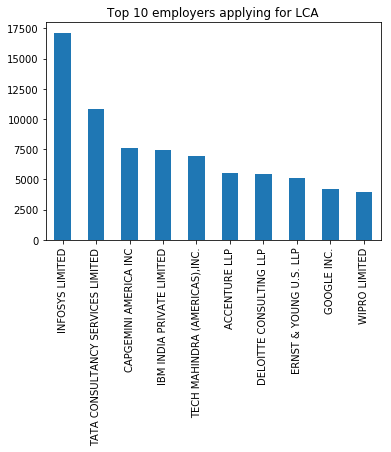

In [28]:
#top employers applying for LCA
df.EMPLOYER_NAME.value_counts()[:10].plot(kind='bar',title = 'Top 10 employers applying for LCA')
plt.show()

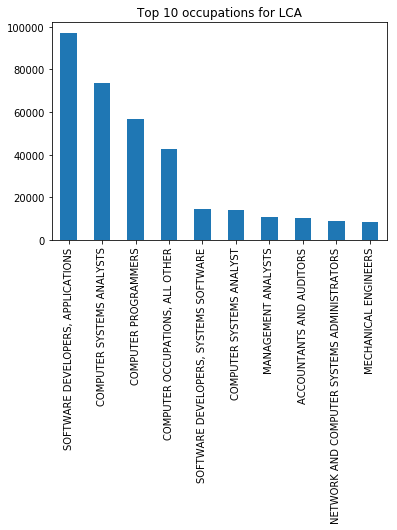

In [29]:
df.SOC_NAME.value_counts()[:10].plot(kind='bar',title = 'Top 10 occupations for LCA')
plt.show()

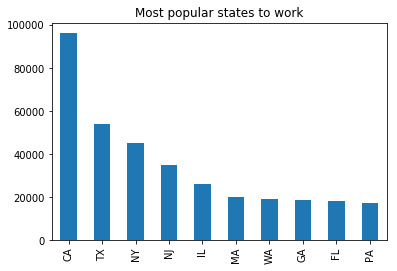

In [30]:
#Most popular states to work in
df.WORKSITE_STATE.value_counts()[:10].plot(kind = 'bar', title = 'Most popular states to work')
plt.show()

# Data PreProcessing

In [31]:
df.select_dtypes(include='object').describe().T

,count,unique,top,freq
CASE_STATUS,503213,4,CERTIFIED,461052
VISA_CLASS,503213,4,H-1B,492902
EMPLOYER_NAME,503213,63578,INFOSYS LIMITED,17145
EMPLOYER_CITY,503213,4839,PLANO,28749
EMPLOYER_STATE,503213,56,CA,86328
EMPLOYER_POSTAL_CODE,503213,10332,75024,18788
EMPLOYER_COUNTRY,503213,5,UNITED STATES OF AMERICA,503202
AGENT_REPRESENTING_EMPLOYER,503213,2,Y,340035
AGENT_ATTORNEY_NAME,503213,6350,",",167835
AGENT_ATTORNEY_CITY,503213,1035,NEW YORK,209679


In [0]:
features_to_encode = df.select_dtypes(include='object').describe().columns

In [33]:
len(features_to_encode)

29

In [34]:
le = LabelEncoder()
# Label all the object variables
for col in features_to_encode:
  encoder = le.fit(df[col].astype(str))
  print(encoder.classes_) 
  df[col] = le.transform(df[col].astype(str))

['CERTIFIED' 'CERTIFIED-WITHDRAWN' 'DENIED' 'WITHDRAWN']
['E-3 Australian' 'H-1B' 'H-1B1 Chile' 'H-1B1 Singapore']
['.CLUB DOMAINS, LLC' '012 GLOBAL INC' '0956588 BC LTD' ...
 'ZZ CAPITAL INTERNATIONAL (US) LLC' 'ZZ VENTURES INC' 'ZZ VENTURES INC.']
[', KENOSHA' ', ROCKVILLE CENTER' ', WASHINGTON DC' ... 'ZEPHYRHILLS'
 'ZIONSVILLE' 'ZUNI']
['AK' 'AL' 'AR' 'AS' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'GU' 'HI'
 'IA' 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MP'
 'MS' 'MT' 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA'
 'PR' 'RI' 'SC' 'SD' 'TN' 'TX' 'UT' 'VA' 'VI' 'VT' 'WA' 'WI' 'WV' 'WY']
['00641' '00646' '00681' ... 'USA' 'V6J 1C7' 'WOODCLIFF LAKE']
['AUSTRALIA' 'CAMBODIA' 'CANADA' 'CHINA' 'UNITED STATES OF AMERICA']
['N' 'Y']
[',' '/HASS, TREVOR' '/HECKLER, /ALAN' ... 'ZWERLING, ARIELLA'
 'ZYMAN, ALEX' 'ZYNE, PHILIP']
['ACTON' 'ADDISON' 'AKRON' ... 'YALAHA' 'YONKERS' 'YORK']
['AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'GU' 'HI' 'IA'
 'ID' 'I

In [0]:
corr = df.corr()

In [36]:
corr

,CASE_STATUS,VISA_CLASS,EMPLOYER_NAME,EMPLOYER_CITY,EMPLOYER_STATE,EMPLOYER_POSTAL_CODE,EMPLOYER_COUNTRY,AGENT_REPRESENTING_EMPLOYER,AGENT_ATTORNEY_NAME,AGENT_ATTORNEY_CITY,...,DECISION_DATE_YEAR,EMPLOYMENT_START_DATE_DAY,EMPLOYMENT_START_DATE_MONTH,EMPLOYMENT_START_DATE_YEAR,EMPLOYMENT_END_DATE_DAY,EMPLOYMENT_END_DATE_MONTH,EMPLOYMENT_END_DATE_YEAR,CASE_SUBMITTED_DAY,CASE_SUBMITTED_MONTH,CASE_SUBMITTED_YEAR
CASE_STATUS,1.000000,-0.016330,0.008507,-0.035957,-0.019065,-0.001194,0.000599,-0.025150,-0.013481,-0.010830,...,0.016401,-0.014547,0.001576,0.003636,0.004247,0.008535,-0.036845,-0.010790,-0.003324,-0.000956
VISA_CLASS,-0.016330,1.000000,0.001836,-0.005393,0.008452,-0.001089,-0.000341,0.000551,0.001360,-0.008757,...,0.035179,0.006306,0.034645,0.025970,0.007314,0.037132,0.161158,-0.002064,-0.041150,0.034833
EMPLOYER_NAME,0.008507,0.001836,1.000000,0.059340,-0.030601,-0.018812,-0.001507,-0.095905,-0.057877,0.072911,...,0.013829,-0.006002,-0.001944,0.011534,0.040606,-0.003419,-0.034118,0.020473,-0.013708,0.014968
EMPLOYER_CITY,-0.035957,-0.005393,0.059340,1.000000,-0.030223,0.079169,-0.003671,0.056705,0.054436,0.145539,...,0.001147,0.007323,-0.028869,-0.001696,-0.000287,-0.039770,0.038118,0.008015,-0.005681,0.003124
EMPLOYER_STATE,-0.019065,0.008452,-0.030601,-0.030223,1.000000,-0.263452,0.006140,-0.191499,-0.126566,0.002807,...,-0.006470,0.002907,-0.004333,-0.004074,0.025287,0.002617,-0.023564,0.023940,0.004170,-0.006211
EMPLOYER_POSTAL_CODE,-0.001194,-0.001089,-0.018812,0.079169,-0.263452,1.000000,-0.003100,0.017392,-0.020896,-0.053617,...,0.002985,-0.001190,0.002293,0.013194,-0.029847,-0.008228,0.071568,-0.008082,-0.014849,0.002415
EMPLOYER_COUNTRY,0.000599,-0.000341,-0.001507,-0.003671,0.006140,-0.003100,1.000000,-0.001955,-0.001821,0.004678,...,0.003291,-0.003404,-0.001618,0.003664,-0.002593,-0.001485,0.000934,0.000073,-0.002001,0.003043
AGENT_REPRESENTING_EMPLOYER,-0.025150,0.000551,-0.095905,0.056705,-0.191499,0.017392,-0.001955,1.000000,0.688109,-0.189944,...,0.045186,0.037349,0.040828,0.031842,-0.081959,0.025025,0.128624,-0.027023,-0.032510,0.052985
AGENT_ATTORNEY_NAME,-0.013481,0.001360,-0.057877,0.054436,-0.126566,-0.020896,-0.001821,0.688109,1.000000,-0.096471,...,0.020052,0.020194,0.022891,0.020891,-0.069012,0.011454,0.092399,-0.044434,-0.027369,0.024285
AGENT_ATTORNEY_CITY,-0.010830,-0.008757,0.072911,0.145539,0.002807,-0.053617,0.004678,-0.189944,-0.096471,1.000000,...,-0.015613,0.002809,-0.034207,-0.007855,0.018917,-0.026087,-0.048965,0.019290,0.018291,-0.017028


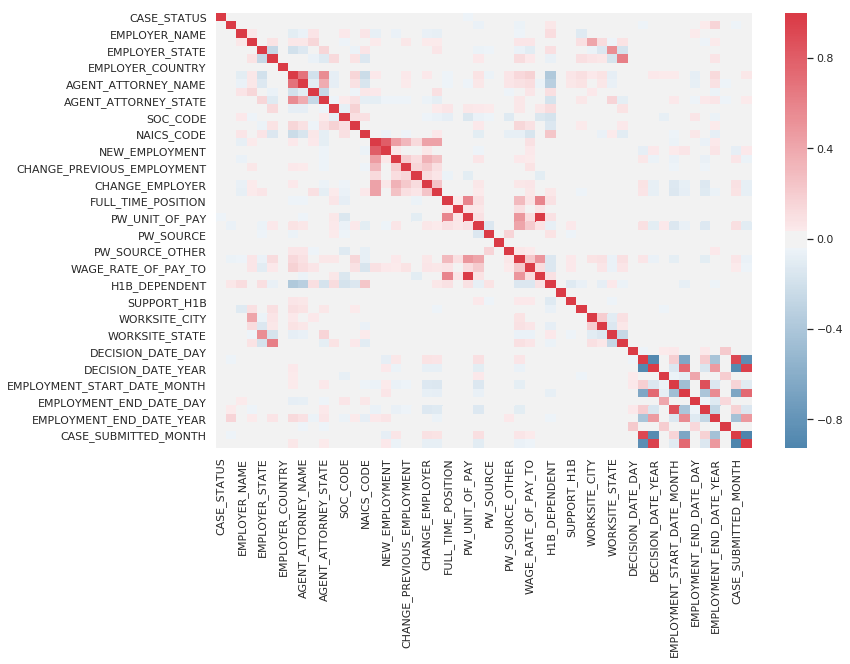

In [37]:
sns.set()
plt.subplots(figsize = (12,8))
color = sns.diverging_palette(240, 10, n=9,as_cmap= True)
sns.heatmap(corr,center= 0,cmap = color)
plt.show()

**Separate the Target Variable**




In [0]:
X = df.drop(labels='CASE_STATUS', axis=1)
y = df['CASE_STATUS']

In [39]:
X.shape

(503213, 51)

In [40]:
y.shape

(503213,)

**Split the data into training and testing**

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

In [0]:
def scale_features(X):
  scaler = MinMaxScaler()
  scaler.fit(X)
  X = scaler.transform(X)
  return X

In [44]:
X_train = scale_features(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [45]:
X_test = scale_features(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [46]:
X_train[:2]

array([[0.33333333, 0.22956415, 0.23646135, 0.12727273, 0.0611751 ,
        1.        , 1.        , 0.16270279, 0.13539652, 0.07407407,
        0.7458948 , 0.18621701, 0.8835443 , 0.75848485, 0.16129032,
        0.16666667, 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.06275051, 1.        , 0.        ,
        0.5       , 0.99950421, 0.47058824, 0.04061434, 0.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ,
        0.29314129, 0.36213125, 0.10714286, 0.05433849, 0.53333333,
        0.18181818, 1.        , 0.3       , 0.72727273, 0.66666667,
        0.3       , 0.72727273, 0.8       , 0.4       , 0.18181818,
        1.        ],
       [0.33333333, 0.61791214, 0.09218685, 0.09090909, 0.90068725,
        1.        , 1.        , 0.16270279, 0.7959381 , 0.07407407,
        0.54925599, 0.18621701, 0.8835443 , 0.75787879, 0.00645161,
        0.        , 0.        , 0.        , 0.        , 0.00666667,
        0.        , 1.     

In [47]:
X_test[:2]

array([[3.33333333e-01, 1.43746953e-01, 3.07182778e-01, 8.54545455e-01,
        7.07619324e-01, 1.00000000e+00, 1.00000000e+00, 1.42857143e-01,
        7.35976789e-01, 8.67924528e-01, 9.22326358e-01, 1.77159590e-01,
        2.45880862e-01, 7.57961783e-01, 0.00000000e+00, 0.00000000e+00,
        1.81818182e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 3.24239228e-04, 1.00000000e+00,
        0.00000000e+00, 5.00000000e-01, 1.00000000e+00, 4.70384782e-01,
        5.22992000e-02, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.16323731e-02,
        5.30563083e-01, 2.85714286e-01, 6.33108979e-01, 4.66666667e-01,
        9.09090909e-02, 1.00000000e+00, 4.33333333e-01, 5.45454545e-01,
        7.50000000e-01, 4.33333333e-01, 5.45454545e-01, 9.09090909e-01,
        2.66666667e-01, 9.09090909e-02, 1.00000000e+00],
       [3.33333333e-01, 4.33663117e-01, 6.99855102e-01, 8.54545455e-01,
       

# Data Imbalance 


> **we found that in our dataset data is imbalance, so we will be applying oversampling mechanism to treat data imbalnce.**


**Before Data Imbalnce**

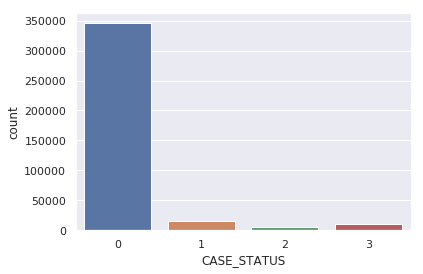

In [48]:
sns.countplot(y_train)
plt.show()

In [0]:
from imblearn.over_sampling import RandomOverSampler

In [0]:
ros = RandomOverSampler(random_state=0)

In [0]:
X_train_bal, y_train_bal = ros.fit_sample(X_train, y_train)

In [52]:
X_train_bal.shape

(1382736, 51)

In [53]:
y_train.shape

(377409,)

**After treating data imbalance using Random Over Sampling**

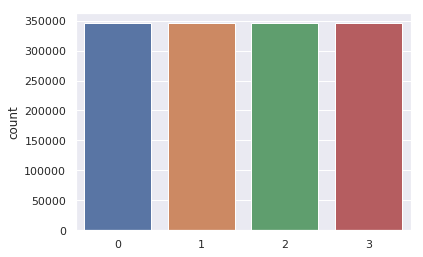

In [54]:
sns.countplot(y_train_bal)
plt.show()

In [55]:
X_train.shape

(377409, 51)

In [56]:
y_train.shape

(377409,)

In [57]:
X_test.shape

(125804, 51)

# Model Fitting

> Since this is a multi class problem so simple classifier problem won't work. We need to use multi class classifier, one of such model is OneVsRest Classifier. 

---


> *OneVsRest Classifier creates classifiers equal to the number of classes and use each of them to predict one class as 1 and other classes as 0s. Then it combine all the classifiers and obtain a single new classifier which assigns probabilities to instances belonging to every class. On encountering a new instance, it will output probability of that instance belonging to every class and in general it select it as the highest of the predicted probabilities.*

---


we are goint to use below models to evaluate our model performance:

* Linear Regression
* Naive Bayes
* Decision Tree
* Random Forest Classifier
* Gradient Boosting Classifier
* Support Vector Machine






In [0]:
# All the models
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# metrics
from sklearn.metrics import accuracy_score,average_precision_score, precision_recall_curve, f1_score, roc_auc_score, recall_score

#hyper-parameter tuning
from sklearn.model_selection import GridSearchCV

In [0]:
def fitAndPredict(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_score = accuracy_score(y_test, y_pred)
  prec_score = precision_score(y_test, y_pred, average='macro')
  f1score = f1_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  print("Accuracy Score:{}".format(acc_score))
  print("Precision Score:{}".format(prec_score))
  print("F1 Score:{}".format(f1score))
  print("Recall:{}".format(recall))
  return acc_score, prec_score, f1score, recall
#   print("ROC score:{}".format(roc_auc_score())

# Binary Classifier

In [60]:
gnb = GaussianNB()
gnb_metrics = fitAndPredict(gnb, X_train_bal, X_test, y_train_bal, y_test)

Accuracy Score:0.018433436138755525
Precision Score:0.2630648630998084
F1 Score:0.03277125421763779
Recall:0.24410898610880524


In [61]:
dt = DecisionTreeClassifier(random_state=0)
dt_metrics = fitAndPredict(dt, X_train_bal, X_test, y_train_bal, y_test)

Accuracy Score:0.9257575275825888
Precision Score:0.566871787352314
F1 Score:0.5998105820151839
Recall:0.6459111929727859


In [62]:
rf = RandomForestClassifier(random_state=0)
rf_metrics = fitAndPredict(rf, X_train_bal, X_test, y_train_bal, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy Score:0.9397236971797399
Precision Score:0.6898749080738505
F1 Score:0.4783981456312508
Recall:0.42509614435385834


In [0]:
df_binary_metrics = pd.DataFrame({"Naive Bias":gnb_metrics, "Decision Tree":dt_metrics, "Random Forest":rf_metrics}, index=['accuracy_score', 'precision_score', 'f1score', 'recall'])

In [95]:
df_binary_metrics

,Naive Bias,Decision Tree,Random Forest
accuracy_score,0.018433,0.925758,0.939724
precision_score,0.263065,0.566872,0.689875
f1score,0.032771,0.599811,0.478398
recall,0.244109,0.645911,0.425096


# OneVsRest Classifier

In [66]:
over_rf = OneVsRestClassifier(RandomForestClassifier(random_state=0, n_jobs=-1))
ovr_rf_metrics = fitAndPredict(over_rf, X_train_bal, X_test, y_train_bal, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy Score:0.9491828558710375
Precision Score:0.7487849142519188
F1 Score:0.5503323125137257
Recall:0.4919250277408538


In [78]:
over_dt = OneVsRestClassifier(DecisionTreeClassifier(random_state=0))
over_df_metrics = fitAndPredict(over_dt, X_train_bal, X_test, y_train_bal, y_test)

Accuracy Score:0.8426282153190677
Precision Score:0.5064258948123672
F1 Score:0.5337697801270582
Recall:0.6438142753062229


In [70]:
ovr_nb = OneVsRestClassifier(GaussianNB())
ovr_nb_metrics = fitAndPredict(ovr_nb, X_train_bal, X_test, y_train_bal, y_test)

Accuracy Score:0.01817907220756097
Precision Score:0.2620588052520352
F1 Score:0.032345318675601746
Recall:0.24496520599782043


In [0]:
import xgboost as xgb

In [0]:
ovr_gb = OneVsRestClassifier(xgb.XGBClassifier(max_depth =10, learning_rate =1, n_jobs =-1))
ovr_gb_metrics = fitAndPredict(ovr_gb, X_train_bal, X_test, y_train_bal, y_test)

In [0]:
df_ovr_metrics = pd.DataFrame({"Naive Bias":ovr_nb_metrics, "Decision Tree":over_df_metrics, "Random Forest":ovr_rf_metrics}, index=['accuracy_score', 'precision_score', 'f1score', 'recall'])

In [97]:
df_ovr_metrics

,Naive Bias,Decision Tree,Random Forest
accuracy_score,0.018179,0.842628,0.949183
precision_score,0.262059,0.506426,0.748785
f1score,0.032345,0.533770,0.550332
recall,0.244965,0.643814,0.491925


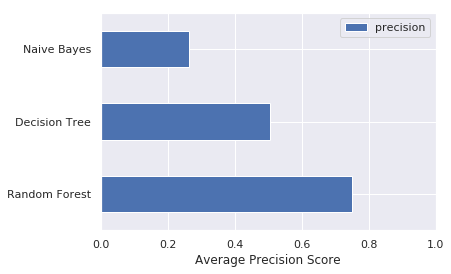

In [89]:
# Dataframe to hold the results
model_comparison_precision = pd.DataFrame({'model': ['Naive Bayes' , 'Decision Tree',
                                           'Random Forest'],
                                 'precision': [ovr_nb_metrics[1], over_df_metrics[1], ovr_rf_metrics[1]]})

model_comparison_precision.sort_values('precision',ascending = False).plot(x = 'model',y = 'precision', kind = 'barh')

plt.ylabel('')
plt.xlabel('Average Precision Score')
plt.xlim((0,1))
plt.show()

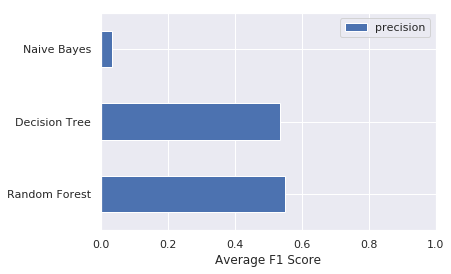

In [91]:
# Dataframe to hold the results
model_comparison_precision = pd.DataFrame({'model': ['Naive Bayes' , 'Decision Tree',
                                           'Random Forest'],
                                 'precision': [ovr_nb_metrics[2], over_df_metrics[2], ovr_rf_metrics[2]]})

model_comparison_precision.sort_values('precision',ascending = False).plot(x = 'model',y = 'precision', kind = 'barh')

plt.ylabel('')
plt.xlabel('Average F1 Score')
plt.xlim((0,1))
plt.show()

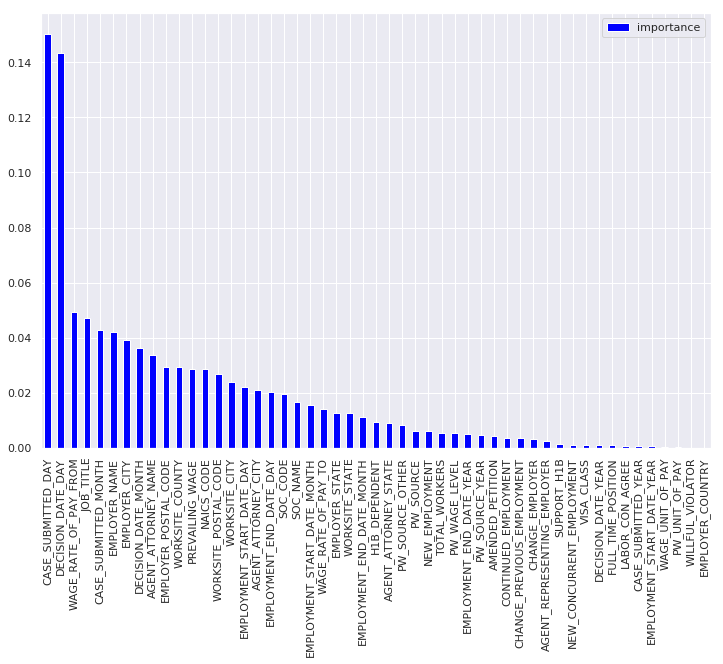

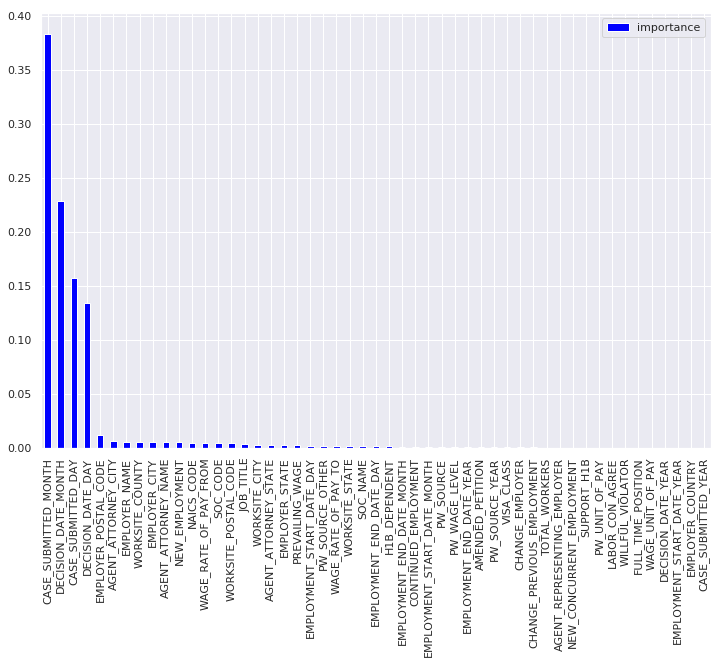

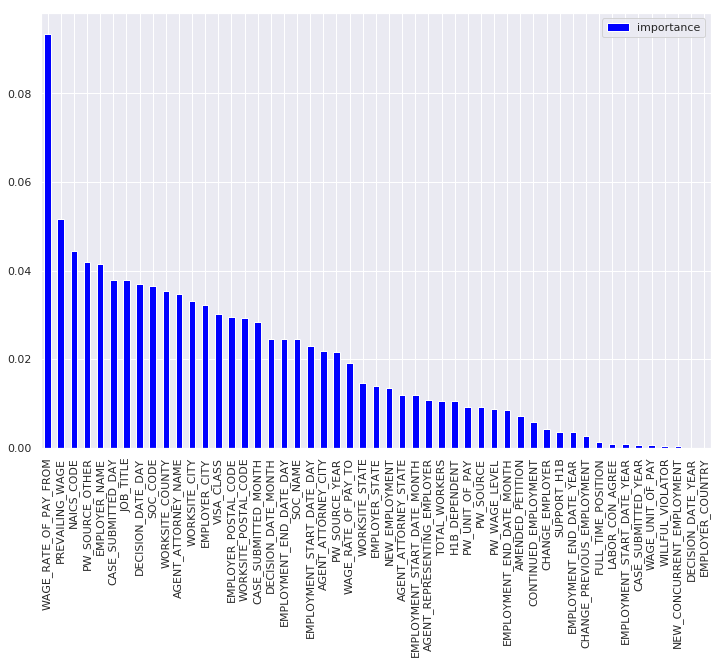

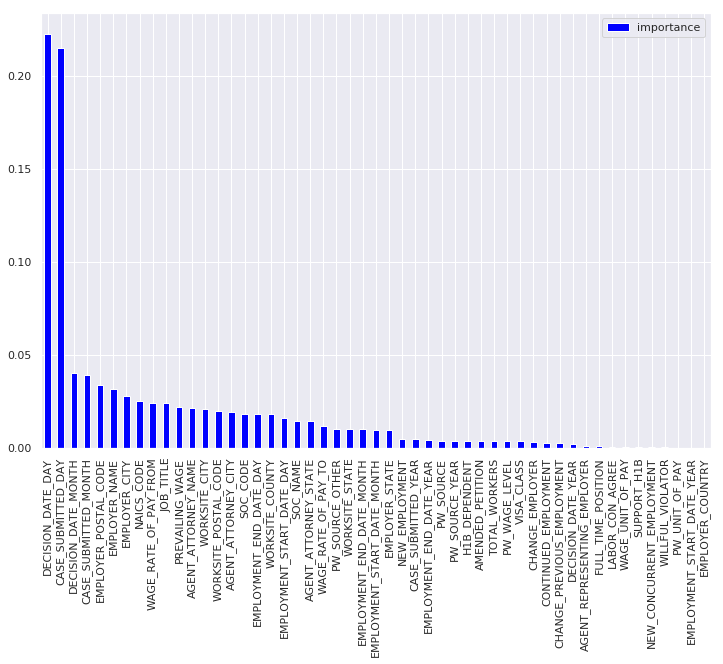

In [121]:

for i in range(4):
  feature_importances = pd.DataFrame(over_rf.estimators_[i].feature_importances_,
                                     index = X.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)
  feature_importances.plot(kind='bar', figsize=(12,8), color='blue')
  plt.show()

<Figure size 1728x1152 with 0 Axes>

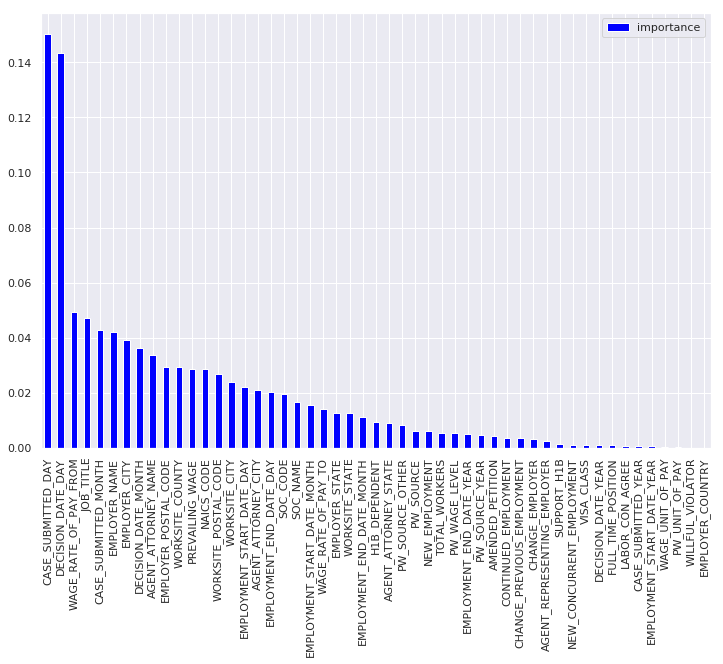

In [117]:
feature_importances

,importance
CASE_SUBMITTED_DAY,0.150425
DECISION_DATE_DAY,0.143460
WAGE_RATE_OF_PAY_FROM,0.049153
JOB_TITLE,0.047079
CASE_SUBMITTED_MONTH,0.042733
EMPLOYER_NAME,0.042204
EMPLOYER_CITY,0.039002
DECISION_DATE_MONTH,0.036181
AGENT_ATTORNEY_NAME,0.033611
EMPLOYER_POSTAL_CODE,0.029358
